In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 22s 244ms/step - loss: 0.3142 - root_mean_squared_error: 0.5605 - val_loss: 0.1625 - val_root_mean_squared_error: 0.4031
Epoch 2/50
53/53 [==============================] - 12s 234ms/step - loss: 0.2433 - root_mean_squared_error: 0.4933 - val_loss: 0.0818 - val_root_mean_squared_error: 0.2861
Epoch 3/50
53/53 [==============================] - 11s 205ms/step - loss: 0.0528 - root_mean_squared_error: 0.2298 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1478
Epoch 4/50
53/53 [==============================] - 1s 28ms/step - loss: 0.0263 - root_mean_squared_error: 0.1621 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1484
Epoch 5/50
53/53 [==============================] - 11s 216ms/step - loss: 0.0256 - root_mean_squared_error: 0.1599 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1448
Epoch 6/50
53/53 [==============================] - 12s 224ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577 - val_loss: 0.0206 - 

53/53 [==============================] - 11s 205ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 30/50
53/53 [==============================] - 10s 199ms/step - loss: 0.0187 - root_mean_squared_error: 0.1368 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1282
Epoch 31/50
53/53 [==============================] - 11s 213ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1279
Epoch 32/50
53/53 [==============================] - 12s 228ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1275
Epoch 33/50
53/53 [==============================] - 11s 217ms/step - loss: 0.0176 - root_mean_squared_error: 0.1328 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1262
Epoch 34/50
53/53 [==============================] - 12s 234ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0158 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

7.998815580209096 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

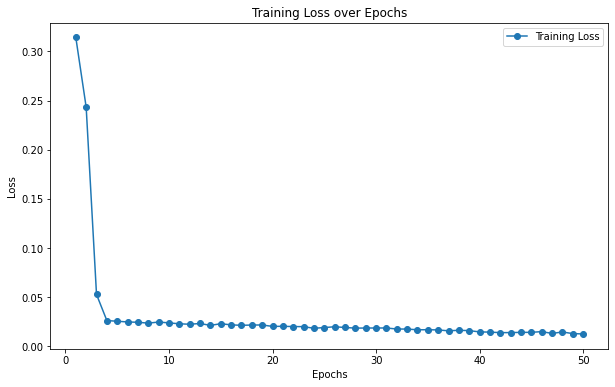

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

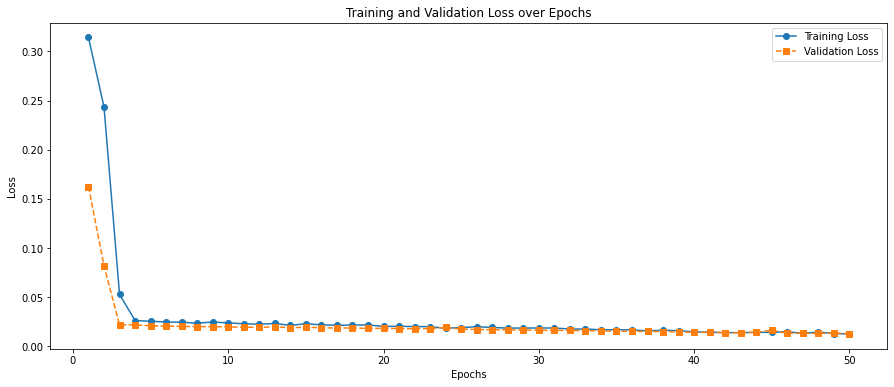

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 19ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.1019217345491086
MAE : 0.08017761175969303


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,319431.50000,283162.646
1,316278.59375,212475.431
2,342197.43750,386546.857
3,386856.59375,547183.986
4,463851.81250,584596.262
5,558356.06250,584830.109
6,611854.00000,641562.292
7,647296.81250,734946.437
8,654743.50000,777596.225
9,620684.00000,687087.673


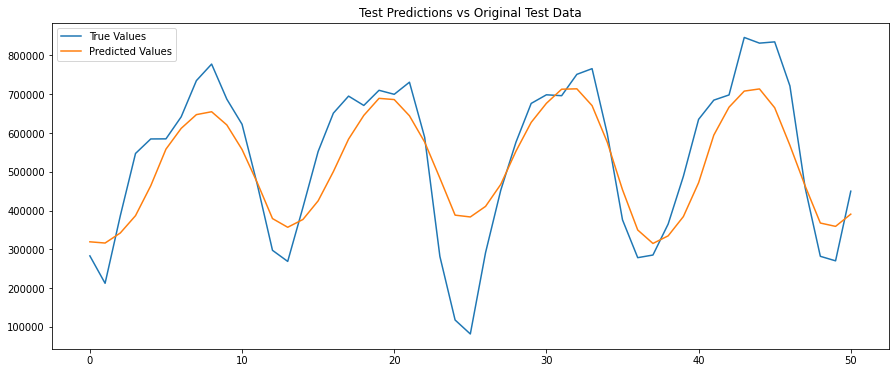

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 18ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

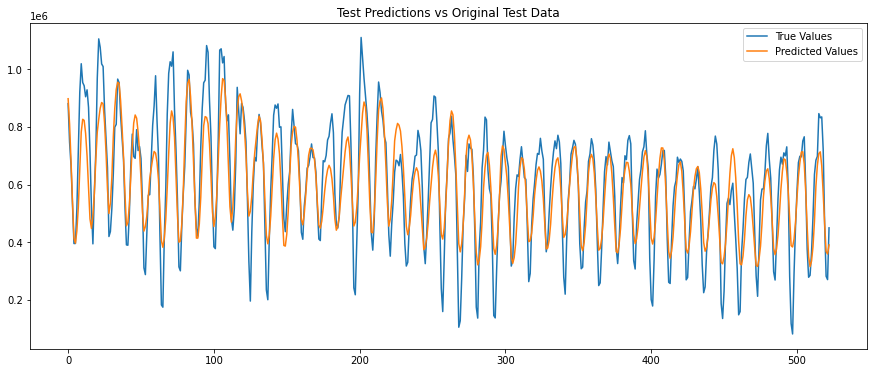

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()